In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
from langgraph.graph import END, START, StateGraph, MessagesState
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from typing import Literal

In [2]:
@tool
def get_weather(location: str):
    """Call to get the current weather."""
    if location.lower() in ["서울"]:
        return "기온은 섭씨 15도이고 흐립니다."
    else:
        return "기온은 섭씨 30도이고 화창합니다."

In [3]:
get_weather.invoke(input={"location": "서울"})

'기온은 섭씨 15도이고 흐립니다.'

In [ ]:
tools = [get_weather]
llm = ChatOpenAI(model="gpt-4o-mini").bind_tools(tools)

In [6]:
llm.invoke("안녕?")

AIMessage(content='안녕하세요. 제가 도와드릴 수 있는 일이 있나요?', additional_kwargs={'usage': {'prompt_tokens': 225, 'completion_tokens': 33, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 258}, 'stop_reason': 'end_turn', 'thinking': {}, 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0', 'model_name': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 225, 'completion_tokens': 33, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 258}, 'stop_reason': 'end_turn', 'thinking': {}, 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0', 'model_name': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run--545d88a4-d67b-4bd8-ba9b-d339cdb18ae2-0', usage_metadata={'input_tokens': 225, 'output_tokens': 33, 'total_tokens': 258, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}})

In [7]:
llm.invoke("서울의 날씨는 어때?")

AIMessage(content='알겠습니다. 서울의 현재 날씨를 알아보겠습니다.', additional_kwargs={'usage': {'prompt_tokens': 233, 'completion_tokens': 85, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 318}, 'stop_reason': 'tool_use', 'thinking': {}, 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0', 'model_name': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 233, 'completion_tokens': 85, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 318}, 'stop_reason': 'tool_use', 'thinking': {}, 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0', 'model_name': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run--c5c69e42-c9e9-4106-a82d-c02c5f141f32-0', tool_calls=[{'name': 'get_weather', 'args': {'location': '서울'}, 'id': 'toolu_bdrk_017jjmfsoS9kJJhE51a7SEV6', 'type': 'tool_call'}], usage_metadata={'input_tokens': 233, 'output_tokens': 85, 'total_tokens': 318, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}

In [17]:
def call_model(state: MessagesState):
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}


def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [18]:
workflow = StateGraph(MessagesState)
tool_node = ToolNode(tools)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

In [19]:
workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

In [20]:
graph = workflow.compile()

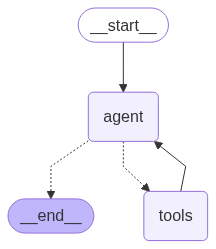

In [21]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [24]:
from langchain_core.messages import HumanMessage

messages1 = [HumanMessage(content="안녕?")]
messages2 = [HumanMessage(content="서울의 날씨는 어때?")]

In [ ]:
graph.invoke({"messages": messages1})

{'messages': [HumanMessage(content='서울의 날씨는 어때?', additional_kwargs={}, response_metadata={}, id='5ea185af-ae79-429b-bec6-198f1b32b0f8'),
  AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 233, 'completion_tokens': 54, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 287}, 'stop_reason': 'tool_use', 'thinking': {}, 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0', 'model_name': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 233, 'completion_tokens': 54, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 287}, 'stop_reason': 'tool_use', 'thinking': {}, 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0', 'model_name': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run--724880fa-7ea3-48c5-9efa-85c50b72f6a7-0', tool_calls=[{'name': 'get_weather', 'args': {'location': '서울'}, 'id': 'toolu_bdrk_015EL6z5Y4JsDkRqGBVmbUFd', 'type': 'tool_call'}], usage_metadata={'input_tok

In [26]:
graph.invoke(
    {
        "messages": [
            HumanMessage(content="그 도시는 어떤게 유명해?")
        ]
    }
)

{'messages': [HumanMessage(content='그 도시는 어떤게 유명해?', additional_kwargs={}, response_metadata={}, id='56f8a30b-8886-4846-af2a-d4280e5e6776'),
  AIMessage(content='죄송합니다. 어떤 도시에 대해 말씀하시는지 구체적으로 명시해주시면 그 도시의 유명한 특징이나 명소에 대해 자세히 알려드리겠습니다.', additional_kwargs={'usage': {'prompt_tokens': 236, 'completion_tokens': 131, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 367}, 'stop_reason': 'tool_use', 'thinking': {}, 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0', 'model_name': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 236, 'completion_tokens': 131, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 367}, 'stop_reason': 'tool_use', 'thinking': {}, 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0', 'model_name': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run--25628b07-e4ed-4d1f-a091-e22887907ade-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Seoul'}, 'id': 'toolu_b

### Add Memory to chatbot

In [27]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

In [ ]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

graph = workflow.compile(checkpointer=checkpointer)

In [29]:
graph.invoke(
    {"messages": [HumanMessage(content="서울의 날씨는 어때?")]},
    config={"configurable": {"thread_id": 1}},
)

{'messages': [HumanMessage(content='서울의 날씨는 어때?', additional_kwargs={}, response_metadata={}, id='7142ebed-090c-48a1-a6b2-13e6261681ac'),
  AIMessage(content='알겠습니다. 서울 지역의 현재 날씨 정보를 가져오기 위해 툴을 호출하겠습니다.', additional_kwargs={'usage': {'prompt_tokens': 233, 'completion_tokens': 103, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 336}, 'stop_reason': 'tool_use', 'thinking': {}, 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0', 'model_name': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 233, 'completion_tokens': 103, 'cache_read_input_tokens': 0, 'cache_write_input_tokens': 0, 'total_tokens': 336}, 'stop_reason': 'tool_use', 'thinking': {}, 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0', 'model_name': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run--26019c91-19b9-444f-9702-270567eb1e97-0', tool_calls=[{'name': 'get_weather', 'args': {'location': '서울'}, 'id': 'toolu_bdrk_0133L4VckwGWbz69jJkZuDSr', 'typ

In [ ]:
graph.invoke(
    {
        "messages": [
            HumanMessage(content="그 도시는 어떤게 유명해?")
        ]
    },
    config={"configurable": {"thread_id": 1}},
)